In [1]:
import keras
from keras.layers import MaxPooling3D, Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

import math
import random

#from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

#init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


# Data Loading

In [2]:
## GLOBAL VARIABLES
dataset = 'SA'
test_ratio = 0.7
windowSize = 9
shouldApplyPCA = False
numComponentsPCA = 20
shouldUseBigMargin = False

In [3]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    elif name == 'SAA':
        data = sio.loadmat(os.path.join(data_path, 'SalinasA_corrected.mat'))['salinasA_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'SalinasA_gt.mat'))['salinasA_gt']
    
    return data, labels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

# TODO ta metoda modyfikuje dane, a może nie powinna?
# TODO w zbiorze wynikowym moga pojawic sie duplikaty
# TODO przez to, że część danych jest odrzucana, faktyczny testRatio będzie zwykle sporo mniejszy
def spitTrainTestSet2(X, y, testRatio, testSquareSize):
    number_of_pixels = X.shape[0] * X.shape[1]
    pixels_in_test = testRatio * number_of_pixels
    test_squares_count = pixels_in_test / (testSquareSize * testSquareSize)
    test_squares_count_floor = math.floor(test_squares_count)

    failures = 0
    test_squares = np.zeros((test_squares_count_floor, testSquareSize, testSquareSize, X.shape[2]))
    test_squares_labels = np.zeros((test_squares_count_floor, testSquareSize, testSquareSize))
    i = 0
    while i < test_squares_count_floor:
    #for i in range(test_squares_count_floor):
        y_coord = random.randint(0,X.shape[0] - testSquareSize - 1) #pion
        x_coord = random.randint(0,X.shape[1] - testSquareSize - 1) #poziom
        #ten if ma zahardkodowane 20, czyli teraz nigdy do niego nie wejdzie. Zachowanie może i ok, ale trzeba usunac duplikaty z wynikowego zbiotu testowego
        if y[y_coord, x_coord] == 20 or y[y_coord + testSquareSize, x_coord] == 20 or y[y_coord, x_coord + testSquareSize] == 20 or y[y_coord + testSquareSize, x_coord + testSquareSize] == 20:
            failures = failures + 1
        else:
            test_squares[i] = X[y_coord : y_coord + testSquareSize, x_coord : x_coord + testSquareSize, :]
            test_squares_labels[i] = y[y_coord : y_coord + testSquareSize, x_coord : x_coord + testSquareSize] 
            y[y_coord : y_coord + testSquareSize, x_coord : x_coord + testSquareSize] = 0 #20
            i += 1

    print(failures)
    return test_squares_count_floor, test_squares, test_squares_labels, y
    
def spitTrainTestSet3(X, y, testRatio, testSquareSize, markTestSquaresAsBg = True):
    y_copy = np.copy(y)
    number_of_pixels = X.shape[0] * X.shape[1]
    pixels_in_test = testRatio * number_of_pixels
    test_squares_count = pixels_in_test / (testSquareSize * testSquareSize)
    test_squares_count_floor = math.floor(test_squares_count)

    failures = 0
    test_squares = np.zeros((test_squares_count_floor, testSquareSize, testSquareSize, X.shape[2]))
    test_squares_labels = np.zeros((test_squares_count_floor, testSquareSize, testSquareSize))
    i = 0
    while i < test_squares_count_floor:
        y_coord = random.randint(0,X.shape[0] - testSquareSize - 1) #pion
        x_coord = random.randint(0,X.shape[1] - testSquareSize - 1) #poziom
        if y[y_coord, x_coord] == 100 or y[y_coord + testSquareSize, x_coord] == 100 or y[y_coord, x_coord + testSquareSize] == 100 or y[y_coord + testSquareSize, x_coord + testSquareSize] == 100:
            failures = failures + 1
            if failures == 1000 or failures == 3000:
                print(failures)
            if failures == 6000:
                y = y_copy
                raise NameError('Hello there')
        else:
            test_squares[i] = X[y_coord : y_coord + testSquareSize, x_coord : x_coord + testSquareSize, :]
            test_squares_labels[i] = y[y_coord : y_coord + testSquareSize, x_coord : x_coord + testSquareSize] 
            y[y_coord : y_coord + testSquareSize, x_coord : x_coord + testSquareSize] = 100
            i += 1

    print(failures)
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            if y[i,j] == 100 and markTestSquaresAsBg:
                y[i,j] = 0
    return test_squares_count_floor, test_squares, test_squares_labels, y

def countClassesInLabelSquares(classesCount, labelSquares, windowSize, shouldUseBigMargin = False):
    margin = int((windowSize - 1) / 2)
    if shouldUseBigMargin:
        margin = windowSize
    classes_in_squares = np.zeros((classesCount))
    for i in range(labelSquares.shape[0]):
        for j in range(margin, labelSquares.shape[1] - margin):
            for k in range(margin, labelSquares.shape[2] - margin):
                c = int(labelSquares[i, j, k])
                classes_in_squares[c] += 1
    return classes_in_squares 

#can be merged with above
def countClassesInGt(classesCount, gt):
    classes_in_gt = np.zeros((classesCount))
    for i in range(gt.shape[0]):
        for j in range(gt.shape[1]):
            c = int(gt[i, j])
            classes_in_gt[c] += 1
    return classes_in_gt 

def convertSquaresToTestSets(testSquares, testLabelSquares, resultWindowSize, classesInSquares, shouldUseBigMargin = False): #resultWindowSize should be odd
    distanceFromCenter = int((resultWindowSize - 1) / 2) # distanceFromCenter + 1 + distanceFromCenter = resultWindowSize
    margin = int((resultWindowSize - 1) / 2)
    if shouldUseBigMargin:
        margin = resultWindowSize
    testCount = int(classesInSquares)
    #testSet = np.zeros((testCount, resultWindowSize, resultWindowSize, testSquares.shape[3]))
    testSet = np.memmap('testSet1.mymemmap', dtype='float32', mode='w+', shape=(testCount, resultWindowSize, resultWindowSize, testSquares.shape[3]))
    testSetLabels = np.zeros((testCount))
    testSet_GT = np.zeros((testCount, resultWindowSize, resultWindowSize))
    print(margin, testCount)
    for i in range(testSquares.shape[0]):
        for j in range(margin, testSquares.shape[1] - margin):
            for k in range(margin, testSquares.shape[2] - margin):
                if testLabelSquares[i, j, k] != 0:
                    testCount -= 1
                    testSet[testCount] = testSquares[i, j - distanceFromCenter : j + distanceFromCenter + 1, k - distanceFromCenter : k + distanceFromCenter + 1,:]
                    testSetLabels[testCount] = testLabelSquares[i, j, k]
                    testSet_GT[testCount] = testLabelSquares[i, j - distanceFromCenter : j + distanceFromCenter + 1, k - distanceFromCenter : k + distanceFromCenter + 1]
    
    return testSet, testSetLabels, testSet_GT

#------------nie to-------------
def convertSquaresToTestSetsAndTreatBackgroundAsClass(testSquares, testLabelSquares, resultWindowSize): #resultWindowSize should be odd
    margin = int((resultWindowSize - 1) / 2)
    testCount = testLabelSquares.shape[0] * testLabelSquares.shape[1] * testLabelSquares.shape[2]
    testSet = np.memmap('testSet.mymemmap', dtype='float32', mode='w+', shape=(testCount, resultWindowSize, resultWindowSize, testSquares.shape[3]))
    testSet = np.zeros((testCount, resultWindowSize, resultWindowSize, testSquares.shape[3]))
    testSetLabels = np.zeros((testCount))
    testSet_GT = np.zeros((testCount, resultWindowSize, resultWindowSize))
    for i in range(testSquares.shape[0]):
        for j in range(margin, testSquares.shape[1] - margin):
            for k in range(margin, testSquares.shape[2] - margin):
                testCount -= 1
                testSet[testCount] = testSquares[i, j - margin : j + margin + 1, k - margin : k + margin + 1,:]
                testSetLabels[testCount] = testLabelSquares[i, j, k]
                testSet_GT[testCount] = testLabelSquares[i, j - margin : j + margin + 1, k - margin : k + margin + 1]
    
    return testSet, testSetLabels, testSet_GT
#------------------------------------

def countPixelsOtherThanValue(gt, value):
    count = 0
    for i in range(gt.shape[0]):
        for j in range(gt.shape[1]):
            if gt[i, j] != value:
                count += 1
    return count

def countBackgroundPixels(labels):
    count = 0
    for i in range(labels.shape[0]):
        if labels[i] == 0:
            count += 1
    return count

def applyPCA(X, numComponents=75, useKernelPCA=False):
    newX = np.reshape(X, (-1, X.shape[2]))
    if useKernelPCA:
        pca = PCA(n_components=numComponents, whiten=True)
    else:
        pca = KernelPCA(n_components=numComponents, kernel='rbf')
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, treatBgAsClass = False):
    notIncludedPixelValue = 100 if treatBgAsClass else 0 #look to func when squares are selected split3
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.memmap('test1.mymemmap', dtype='float32', mode='w+', shape=(countPixelsOtherThanValue(y, notIncludedPixelValue), windowSize, windowSize, X.shape[2]))
    #patchesData = np.zeros((countPixelsOtherThanValue(y, notIncludedPixelValue), windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((countPixelsOtherThanValue(y, notIncludedPixelValue)))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            if y[r-margin, c-margin] != notIncludedPixelValue:
                patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
                patchesData[patchIndex, :, :, :] = patch
                patchesLabels[patchIndex] = y[r-margin, c-margin]
                patchIndex = patchIndex + 1

    return patchesData, patchesLabels

def balanceSetByTreshold(samples, labels, treshold, numClasses):
    randomIndexes = np.arange(labels.shape[0])
    np.random.shuffle(randomIndexes)
    print(randomIndexes.shape[0])
    counters = np.zeros((numClasses))
    print(counters)
    balancedSamples = []
    balancedLabels = []
    for i in randomIndexes:
        currentClass = int(labels[i])
        counters[currentClass - 1] += 1
        if counters[currentClass - 1] < treshold:
            balancedSamples.append(samples[i])
            balancedLabels.append(labels[i])
    return np.array(balancedSamples), np.array(balancedLabels)
    

(512, 217, 204) (512, 217)


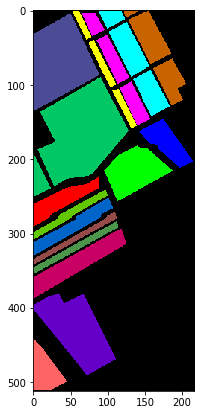

In [10]:

                        #################### <--- REAL FUN STARTS HERE ---> ####################


X, y = loadData(dataset)

print(X.shape, y.shape)

ground_truth = spectral.imshow(classes = y,figsize =(7,7))

In [5]:
if shouldApplyPCA:
    #X,pca = applyPCA(X,numComponents=numComponentsPCA)
    X,pca = applyPCA(X,numComponents=numComponentsPCA, useKernelPCA=True)
    print(X.shape)

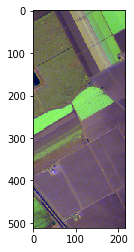

In [6]:
view = spectral.imshow(X, (100,50,0))

In [11]:
testSquaresCount, testSquares, testSquares_GT, y = spitTrainTestSet3(X, y, 0.50, windowSize + 20)#windowSize + 15)
#testSquaresCount, testSquares, testSquares_GT, y = spitTrainTestSet2(X, y, 1, windowSize + 10)
testSquares.shape

1000
1580


(66, 29, 29, 204)

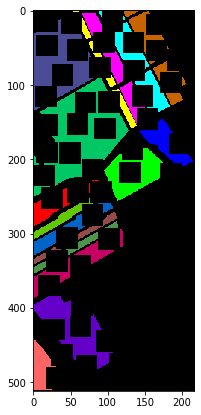

In [12]:
ground_truth = spectral.imshow(classes = y, figsize =(7,7))

In [13]:
#TU JEST ZAHARDCODOWANA ILOSC KLAS. można zrobić count(unique(labels)) albo max(labels)
print(len(np.unique(y)))
classes_in_test_squares = countClassesInLabelSquares(len(np.unique(y)), testSquares_GT, windowSize, shouldUseBigMargin) # 16 classes + 1 for bacground
classes_in_train_set = countClassesInGt(len(np.unique(y)), y)
#brakuje takich samych danych dla treningowego
classes_in_test_squares, classes_in_train_set

17


(array([13879.,   739.,   794.,   280.,   249.,   602.,  1316.,  1209.,
         3333.,  1821.,  1159.,   157.,   566.,   144.,   238.,  2248.,
          372.]),
 array([85318.,   769.,  2236.,  1336.,   784.,  1535.,  1537.,  1306.,
         5022.,  2893.,  1170.,   759.,   961.,   568.,   578.,  3126.,
         1206.]))

In [14]:
classes_in_squares_count = np.sum(classes_in_test_squares[1 : classes_in_test_squares.shape[0]])
print(testSquares.shape, testSquares_GT.shape, windowSize, classes_in_squares_count)
testSet, testSetLabels, testSet_GT = convertSquaresToTestSets(testSquares, testSquares_GT, windowSize, classes_in_squares_count, shouldUseBigMargin)

(66, 29, 29, 204) (66, 29, 29) 9 15227.0
4 15227


In [15]:
testSet.shape, testSetLabels.shape, testSet_GT.shape

((15227, 9, 9, 204), (15227,), (15227, 9, 9))

In [16]:
trainSet, trainSetLabels = createImageCubes(X, y, windowSize=windowSize)

trainSet.shape, trainSetLabels.shape

((25786, 9, 9, 204), (25786,))

In [128]:
#CHYBA NIE POTRZEBNE
#trainSet, trainSetLabels = balanceSetByTreshold(trainSet, trainSetLabels, 3000, 9)

In [17]:
trainSet.shape, testSet.shape, trainSetLabels.shape, testSetLabels.shape

((25786, 9, 9, 204), (15227, 9, 9, 204), (25786,), (15227,))

In [18]:
unique, counts = np.unique(trainSetLabels, return_counts=True)
dict(zip(unique, counts))

{1.0: 769,
 2.0: 2236,
 3.0: 1336,
 4.0: 784,
 5.0: 1535,
 6.0: 1537,
 7.0: 1306,
 8.0: 5022,
 9.0: 2893,
 10.0: 1170,
 11.0: 759,
 12.0: 961,
 13.0: 568,
 14.0: 578,
 15.0: 3126,
 16.0: 1206}

In [19]:
#just to not rename everything in notebook
Xtrain = trainSet
Xtest = testSet
ytrain = trainSetLabels - 1
ytest = testSetLabels - 1

In [18]:
#just to not rename everything in notebook
Xtest = trainSet
Xtrain = testSet
ytest = trainSetLabels - 1
ytrain = testSetLabels - 1

In [20]:
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((25786, 9, 9, 204), (15227, 9, 9, 204), (25786,), (15227,))

# Model and Training

In [21]:
ytrain = np_utils.to_categorical(ytrain)
ytest = np_utils.to_categorical(ytest)
ytrain.shape, ytest.shape

((25786, 16), (15227, 16))

In [49]:
S = windowSize
L = numComponentsPCA if (shouldApplyPCA) else Xtrain.shape[3]
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [68]:
input_layer = Input((S, S, L))

reshape_layer = Reshape((S, S, L, 1))(input_layer)

conv_layer1 = Conv3D(filters=2, kernel_size=(3, 3, 7), strides=(1, 1, 2), activation='relu')(reshape_layer) #7
conv_layer2 = Conv3D(filters=4, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu')(conv_layer1) #5
conv_layer3 = Conv3D(filters=8, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu')(conv_layer2) #5
conv_layer4 = Conv3D(filters=16, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu')(conv_layer3) #5

flatten_layer = Flatten()(conv_layer4)
dense_layer1 = Dense(units=288, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.1)(dense_layer1)
dense_layer2 = Dense(units=144, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.1)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)


#było, ale nie działa
#flatten_layer = Flatten()(conv_layer3)
#dense_layer1 = Dense(units=288, activation='relu')(flatten_layer)
#dense_layer2 = Dense(units=144, activation='relu')(dense_layer1)

In [36]:
## input layer
input_layer = Input((S, S, L))

reshape_layer = Reshape((S, S, L, 1))(input_layer)

#mp3 = MaxPooling3D(pool_size=(1, 1, 2))(conv_layer_1D_3)
## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), strides=(1, 1, 1), activation='relu')(reshape_layer) #7
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), strides=(1, 1, 1), activation='relu')(conv_layer1) #5
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu')(conv_layer2) #3
conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu')(conv_layer3) #3
#mp = MaxPooling3D((3,3,3))(conv_layer4)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=288, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=144, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [69]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [70]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 9, 9, 204)         0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 9, 9, 204, 1)      0         
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 7, 7, 99, 2)       128       
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 5, 5, 97, 4)       220       
_________________________________________________________________
conv3d_35 (Conv3D)           (None, 3, 3, 95, 8)       872       
_________________________________________________________________
conv3d_36 (Conv3D)           (None, 1, 1, 93, 16)      3472      
_________________________________________________________________
flatten_9 (Flatten)          (None, 1488)              0         
__________

In [71]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [72]:
# checkpoint
filepath = "best-model-3D.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [73]:
aug = ImageDataGenerator(fill_mode="nearest")
aug2 = ImageDataGenerator(fill_mode="nearest")
batch_size = 256
#, validation_data=(Xtest, ytest)
history = model.fit_generator(aug.flow(Xtrain, ytrain, batch_size=batch_size), steps_per_epoch=len(Xtrain) // batch_size, epochs=30, validation_data=aug2.flow(Xtest, ytest, batch_size=batch_size), validation_steps=len(Xtest) // batch_size, callbacks=callbacks_list)

Epoch 1/30
100/100 [==============================] - 16s 156ms/step - loss: 2.6487 - acc: 0.3512 - val_loss: 1.2085 - val_acc: 0.4966

Epoch 00001: acc improved from -inf to 0.35117, saving model to best-model-3D.hdf5
Epoch 2/30
100/100 [==============================] - 14s 144ms/step - loss: 0.9468 - acc: 0.6305 - val_loss: 0.8166 - val_acc: 0.6883

Epoch 00002: acc improved from 0.35117 to 0.63075, saving model to best-model-3D.hdf5
Epoch 3/30
100/100 [==============================] - 14s 144ms/step - loss: 0.5465 - acc: 0.7848 - val_loss: 0.5594 - val_acc: 0.7675

Epoch 00003: acc improved from 0.63075 to 0.78496, saving model to best-model-3D.hdf5
Epoch 4/30
100/100 [==============================] - 14s 144ms/step - loss: 0.4152 - acc: 0.8302 - val_loss: 0.5507 - val_acc: 0.7665

Epoch 00004: acc improved from 0.78496 to 0.83020, saving model to best-model-3D.hdf5
Epoch 5/30
100/100 [==============================] - 14s 145ms/step - loss: 0.3210 - acc: 0.8680 - val_loss: 0.522

In [ ]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=5, callbacks=callbacks_list)

# Validation

In [115]:
# load best weights
model.load_weights("best-model-3D.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [116]:
#ytest = np_utils.to_categorical(ytest)
ytest.shape

(14824, 9)

In [117]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2322
           1       0.41      1.00      0.58      5944
           2       0.00      0.00      0.00       916
           3       0.83      0.04      0.07      1002
           4       0.00      0.00      0.00       461
           5       0.00      0.00      0.00      2037
           6       0.00      0.00      0.00       418
           7       0.00      0.00      0.00      1316
           8       0.95      0.40      0.56       408

    accuracy                           0.41     14824
   macro avg       0.24      0.16      0.13     14824
weighted avg       0.25      0.41      0.25     14824



In [33]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

C:\Users\Marcin\Anaconda3\envs\PythonGPU\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

In [34]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [35]:
# load the original image
X, y = loadData(dataset)

In [36]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize

In [37]:
X,pca = applyPCA(X, numComponents=numComponentsPCA)

MemoryError: 

In [55]:
X = padWithZeros(X, PATCH_SIZE//2)

In [56]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2]).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

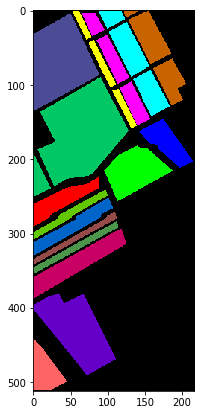

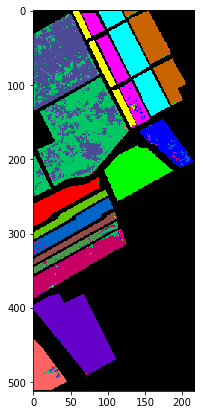

In [57]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [36]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)